In [2]:
import os
import numpy as np
import pandas as pd
import pickle
import joblib

import Models
from AuxiliarFunctions import *

# Carga de Dados

In [3]:
config_file_path = 'data/config.csv'
df_config = pd.read_csv(config_file_path)
train_id = 0

model_type = 'Kernel'

In [4]:
df_data = pd.read_csv(df_config['train_data_path'][train_id])
df_trgt = pd.read_csv(df_config['train_trgt_path'][train_id])

In [5]:
model_path = df_config['model_path'][train_id]
df_choose_hyperparameters = pd.read_csv(os.path.join(model_path,'%s_%s_choose_hyperparameters.csv'%(df_config['hash_id'][train_id], model_type)))

In [6]:
print('Choose hyperparams - kernel %s and loss %s'%(df_choose_hyperparameters['kernel'].values[0],
                                                              df_choose_hyperparameters['loss'].values[0]))

Choose hyperparams - kernel polynomial and loss soft_margin


# Figuras de Mérito de Classificação

In [7]:
train_record = pd.read_csv(os.path.join(model_path,'%s_%s_train_record.csv'%(df_config['hash_id'][train_id], model_type)))
selected_train = train_record[(train_record['kernel']==df_choose_hyperparameters['kernel'].values[0]) & 
                              (train_record['loss']==df_choose_hyperparameters['loss'].values[0])]

In [8]:
train_record = pd.read_csv(os.path.join(model_path,'%s_%s_train_record.csv'%(df_config['hash_id'][train_id], model_type)))

mean_grouped = selected_train[['kernel','loss',
                        'Acc','Sens','Spec','SP', 'AUC', 'Time']].groupby(['kernel', 'loss']).mean()
std_grouped = selected_train[['kernel','loss',
                        'Acc','Sens','Spec','SP', 'AUC', 'Time']].groupby(['kernel', 'loss']).std()
grouped = pd.concat([mean_grouped,std_grouped],axis=0)

grouped

Acc      Sens      Spec        SP       AUC  \
kernel     loss                                                            
polynomial soft_margin  0.849300  0.810041  0.888581  0.720610  0.849311   
           soft_margin  0.011528  0.018193  0.015238  0.019685  0.011529   

                            Time  
kernel     loss                   
polynomial soft_margin  0.601162  
           soft_margin  0.030104

# Matriz de Confusão

Processing Kernel Analysis
Processing Analysis for polynomial kernel
Processing Training for soft_margin loss
Analysing 1 fold of 10 folds

Reading Cross-validation indexes
Done
Reading Pipeline Object
Done
Loading for model
Model is in data/models/-8662869763806803064_Kernel_0_fold_model_polynomial_kernel_soft_margin_loss.pkl
Analysing 2 fold of 10 folds

Reading Cross-validation indexes
Done
Reading Pipeline Object
Done
Loading for model
Model is in data/models/-8662869763806803064_Kernel_1_fold_model_polynomial_kernel_soft_margin_loss.pkl
Analysing 3 fold of 10 folds

Reading Cross-validation indexes
Done
Reading Pipeline Object
Done
Loading for model
Model is in data/models/-8662869763806803064_Kernel_2_fold_model_polynomial_kernel_soft_margin_loss.pkl
Analysing 4 fold of 10 folds

Reading Cross-validation indexes
Done
Reading Pipeline Object
Done
Loading for model
Model is in data/models/-8662869763806803064_Kernel_3_fold_model_polynomial_kernel_soft_margin_loss.pkl
Analysing 5 fo

Text(0.5, 1.0, 'Classification for training set')

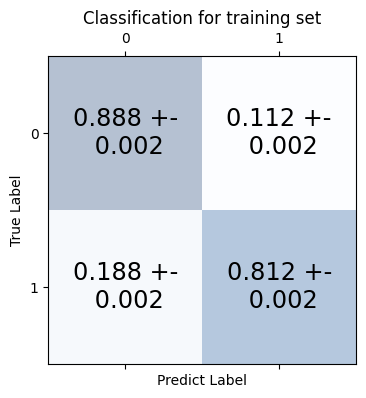

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import time

import copy

model_type = 'Kernel'
n_folds =  df_config['cv_folds'][train_id]

cv_path = df_config['cv_path'][train_id]
pipe_path = df_config['pipeline_path'][train_id]
model_path = df_config['model_path'][train_id]

print('Processing Kernel Analysis')

kernels = [df_choose_hyperparameters['kernel'].values[0]]
losses = [df_choose_hyperparameters['loss'].values[0]]


conf_mat = np.zeros((2,2,n_folds))

for kernel in kernels:
    print('Processing Analysis for %s kernel'%(kernel))
    for loss in losses:
        print('Processing Training for %s loss'%(loss))
        for ifold in range(n_folds):
            #if ifold >= 2: # para desenvolvimento
            #    break
            print('Analysing %i fold of %i folds\n'%(ifold+1, n_folds))
            print('Reading Cross-validation indexes')

            cv_name = '%s_%s_CV_fold_%i_of_%i_cv_indexes.pkl'%(df_config['hash_id'][train_id],
                                                               df_config['cv_alg'][train_id],
                                                               ifold, n_folds)
            print('Done')
            print('Reading Pipeline Object')
            with open(os.path.join(cv_path,cv_name),'rb') as file_handler:
                [trn_idx,val_idx] = pickle.load(file_handler)

            pipe_name ='%s_%s_CV_fold_%i_of_%i_pipe.pkl'%(df_config['hash_id'][train_id],
                                                               df_config['cv_alg'][train_id],
                                                               ifold, n_folds)
            with open(os.path.join(pipe_path,pipe_name),'rb') as file_handler:
                pipe = joblib.load(file_handler)

            print('Done')

            trn_data = pipe.transform(df_data)
            trn_trgt = df_trgt.values # tf.keras.utils.to_categorical(dev_target, num_classes=len(np.unique(dev_target)))

            print('Loading for model')
            model_name = '%s_%s_%i_fold_model_%s_kernel_%s_loss.pkl'%(df_config['hash_id'][train_id],
                                                                                model_type, ifold, kernel, 
                                                                                loss)
            if os.path.exists(os.path.join(model_path, model_name)):
                print('Model is in %s'%(os.path.join(model_path, model_name)))
                prediction_name = copy.copy(model_name)
                prediction_name = prediction_name.replace('.pkl','_prediction_file.csv')
                df_predict = pd.read_csv(os.path.join(model_path, prediction_name))
                (tn, fp, fn, tp) = Models.get_confusion_matrix(df_predict.loc[trn_idx,'target'],
                                                               df_predict.loc[trn_idx,'model_output'])
                #print((tn, fp, fn, tp))
                conf_mat[0,0,ifold] = tn
                conf_mat[0,1,ifold] = fp
                conf_mat[1,0,ifold] = fn
                conf_mat[1,1,ifold] = tp
            else:
                print('No Model \n')

# ============================================== #
#                      Drawing                   #
# ============================================== #
fig, ax = plt.subplots(figsize=(4, 4))
conf_matrix_mean = np.mean(conf_mat,axis=2)
conf_matrix_std = np.std(conf_mat,axis=2)

ax.matshow(conf_matrix_mean, cmap=plt.cm.Blues, alpha=0.3)

for i in range(conf_matrix_mean.shape[0]):
    for j in range(conf_matrix_mean.shape[1]):
        text = '%1.3f +-\n %1.3f'%(conf_matrix_mean[i, j],conf_matrix_std[i, j])
        ax.text(x=j, y=i,s=text, va='center', ha='center', size='xx-large')
ax.set_xlabel('Predict Label')
ax.set_ylabel('True Label')
ax.set_xticks([0,1])
ax.set_title('Classification for training set')

Processing Kernel Analysis
Processing Analysis for polynomial kernel
Processing Training for soft_margin loss
Analysing 1 fold of 10 folds

Reading Cross-validation indexes
Done
Reading Pipeline Object
Done
Loading for model
Model is in data/models/-8662869763806803064_Kernel_0_fold_model_polynomial_kernel_soft_margin_loss.pkl
Analysing 2 fold of 10 folds

Reading Cross-validation indexes
Done
Reading Pipeline Object
Done
Loading for model
Model is in data/models/-8662869763806803064_Kernel_1_fold_model_polynomial_kernel_soft_margin_loss.pkl
Analysing 3 fold of 10 folds

Reading Cross-validation indexes
Done
Reading Pipeline Object
Done
Loading for model
Model is in data/models/-8662869763806803064_Kernel_2_fold_model_polynomial_kernel_soft_margin_loss.pkl
Analysing 4 fold of 10 folds

Reading Cross-validation indexes
Done
Reading Pipeline Object
Done
Loading for model
Model is in data/models/-8662869763806803064_Kernel_3_fold_model_polynomial_kernel_soft_margin_loss.pkl
Analysing 5 fo

Text(0.5, 1.0, 'Classification for validation set')

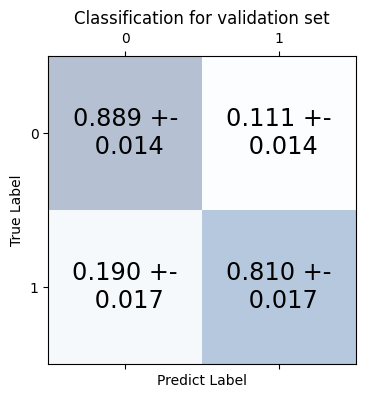

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import time

import copy

model_type = 'Kernel'
n_folds =  df_config['cv_folds'][train_id]

cv_path = df_config['cv_path'][train_id]
pipe_path = df_config['pipeline_path'][train_id]
model_path = df_config['model_path'][train_id]

print('Processing Kernel Analysis')

kernels = [df_choose_hyperparameters['kernel'].values[0]]
losses = [df_choose_hyperparameters['loss'].values[0]]


conf_mat = np.zeros((2,2,n_folds))

for kernel in kernels:
    print('Processing Analysis for %s kernel'%(kernel))
    for loss in losses:
        print('Processing Training for %s loss'%(loss))
        for ifold in range(n_folds):
            #if ifold >= 2: # para desenvolvimento
            #    break
            print('Analysing %i fold of %i folds\n'%(ifold+1, n_folds))
            print('Reading Cross-validation indexes')

            cv_name = '%s_%s_CV_fold_%i_of_%i_cv_indexes.pkl'%(df_config['hash_id'][train_id],
                                                               df_config['cv_alg'][train_id],
                                                               ifold, n_folds)
            print('Done')
            print('Reading Pipeline Object')
            with open(os.path.join(cv_path,cv_name),'rb') as file_handler:
                [trn_idx,val_idx] = pickle.load(file_handler)

            pipe_name ='%s_%s_CV_fold_%i_of_%i_pipe.pkl'%(df_config['hash_id'][train_id],
                                                               df_config['cv_alg'][train_id],
                                                               ifold, n_folds)
            with open(os.path.join(pipe_path,pipe_name),'rb') as file_handler:
                pipe = joblib.load(file_handler)

            print('Done')

            trn_data = pipe.transform(df_data)
            trn_trgt = df_trgt.values # tf.keras.utils.to_categorical(dev_target, num_classes=len(np.unique(dev_target)))

            print('Loading for model')
            model_name = '%s_%s_%i_fold_model_%s_kernel_%s_loss.pkl'%(df_config['hash_id'][train_id],
                                                                                model_type, ifold, kernel, 
                                                                                loss)
            if os.path.exists(os.path.join(model_path, model_name)):
                print('Model is in %s'%(os.path.join(model_path, model_name)))
                prediction_name = copy.copy(model_name)
                prediction_name = prediction_name.replace('.pkl','_prediction_file.csv')
                df_predict = pd.read_csv(os.path.join(model_path, prediction_name))
                (tn, fp, fn, tp) = Models.get_confusion_matrix(df_predict.loc[val_idx,'target'],
                                                               df_predict.loc[val_idx,'model_output'])
                #print((tn, fp, fn, tp))
                conf_mat[0,0,ifold] = tn
                conf_mat[0,1,ifold] = fp
                conf_mat[1,0,ifold] = fn
                conf_mat[1,1,ifold] = tp
            else:
                print('No Model \n')

# ============================================== #
#                      Drawing                   #
# ============================================== #
fig, ax = plt.subplots(figsize=(4,4))
conf_matrix_mean = np.mean(conf_mat,axis=2)
conf_matrix_std = np.std(conf_mat,axis=2)

ax.matshow(conf_matrix_mean, cmap=plt.cm.Blues, alpha=0.3)

for i in range(conf_matrix_mean.shape[0]):
    for j in range(conf_matrix_mean.shape[1]):
        text = '%1.3f +-\n %1.3f'%(conf_matrix_mean[i, j],conf_matrix_std[i, j])
        ax.text(x=j, y=i,s=text, va='center', ha='center', size='xx-large')
ax.set_xlabel('Predict Label')
ax.set_ylabel('True Label')
ax.set_xticks([0,1])
ax.set_title('Classification for validation set')

# Análise de Relevância

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import time

import copy

model_type = 'Kernel'
n_folds =  df_config['cv_folds'][train_id]

cv_path = df_config['cv_path'][train_id]
pipe_path = df_config['pipeline_path'][train_id]
model_path = df_config['model_path'][train_id]

print('Processing Kernel Analysis')

kernels = [df_choose_hyperparameters['kernel'].values[0]]
losses = [df_choose_hyperparameters['loss'].values[0]]


conf_mat = np.zeros((2,2,n_folds))

relevance = np.zeros((df_data.shape[1], n_folds))
reference = np.zeros((1, n_folds))

df_relevance = None


for kernel in kernels:
    print('Processing Analysis for %s kernel'%(kernel))
    for loss in losses:
        print('Processing Training for %s loss'%(loss))
        for ifold in range(n_folds):
            #if ifold >= 2: # para desenvolvimento
            #    break
            print('Analysing %i fold of %i folds\n'%(ifold+1, n_folds))
            print('Reading Cross-validation indexes')

            cv_name = '%s_%s_CV_fold_%i_of_%i_cv_indexes.pkl'%(df_config['hash_id'][train_id],
                                                               df_config['cv_alg'][train_id],
                                                               ifold, n_folds)
            print('Done')
            print('Reading Pipeline Object')
            with open(os.path.join(cv_path,cv_name),'rb') as file_handler:
                [trn_idx,val_idx] = pickle.load(file_handler)

            pipe_name ='%s_%s_CV_fold_%i_of_%i_pipe.pkl'%(df_config['hash_id'][train_id],
                                                               df_config['cv_alg'][train_id],
                                                               ifold, n_folds)
            with open(os.path.join(pipe_path,pipe_name),'rb') as file_handler:
                pipe = joblib.load(file_handler)

            print('Done')

            trn_data = pipe.transform(df_data)
            trn_trgt = df_trgt.values # tf.keras.utils.to_categorical(dev_target, num_classes=len(np.unique(dev_target)))

            print('Loading for model')
            model_name = '%s_%s_%i_fold_model_%s_kernel_%s_loss.pkl'%(df_config['hash_id'][train_id],
                                                                                model_type, ifold, kernel, 
                                                                                loss)
            if os.path.exists(os.path.join(model_path, model_name)):
                print('Model is in %s'%(os.path.join(model_path, model_name)))
                prediction_name = copy.copy(model_name)
                prediction_name = prediction_name.replace('.pkl','_prediction_file.csv')
                df_predict = pd.read_csv(os.path.join(model_path, prediction_name))
                ref_value = Models.accuracy_score(df_predict.loc[trn_idx,'target'],
                                                  df_predict.loc[trn_idx,'model_output'])
                reference[:,ifold] = ref_value
                
                model = Models.KernelClassifier()
                model.load(os.path.join(model_path, model_name))

                for iinput in range(df_data.shape[1]):
                    print('Analysing for %i input in'%(iinput),df_data.shape[1])
                    buffer_data = np.copy(trn_data)
                    buffer_data[:,iinput] = np.mean(buffer_data[:,iinput])
                    predictions = model.predict(buffer_data)
                    
                    value = Models.accuracy_score(df_predict.loc[trn_idx,'target'],
                                                  predictions[trn_idx])
                    relevance[iinput,ifold] = value
            else:
                print('No Model \n')
df_relevance = pd.DataFrame(data=relevance, 
                            columns=range(n_folds),
                            index=list(df_data.columns))
df_reference = pd.DataFrame(data=reference,columns=range(n_folds), index=['Reference'])
df_relevance = pd.concat([df_relevance,df_reference],axis=0)

df_relevance.to_csv(os.path.join(model_path, '%s_%s_relevance.csv'%(df_config['hash_id'][train_id], model_type)))

Processing Kernel Analysis
Processing Analysis for polynomial kernel
Processing Training for soft_margin loss
Analysing 1 fold of 10 folds

Reading Cross-validation indexes
Done
Reading Pipeline Object
Done
Loading for model
Model is in data/models/-8662869763806803064_Kernel_0_fold_model_polynomial_kernel_soft_margin_loss.pkl
Analysing for 0 input in 4
Analysing for 1 input in 4
Analysing for 2 input in 4
Analysing for 3 input in 4
Analysing 2 fold of 10 folds

Reading Cross-validation indexes
Done
Reading Pipeline Object
Done
Loading for model
Model is in data/models/-8662869763806803064_Kernel_1_fold_model_polynomial_kernel_soft_margin_loss.pkl
Analysing for 0 input in 4
Analysing for 1 input in 4
Analysing for 2 input in 4
Analysing for 3 input in 4
Analysing 3 fold of 10 folds

Reading Cross-validation indexes
Done
Reading Pipeline Object
Done
Loading for model
Model is in data/models/-8662869763806803064_Kernel_2_fold_model_polynomial_kernel_soft_margin_loss.pkl
Analysing for 0 i

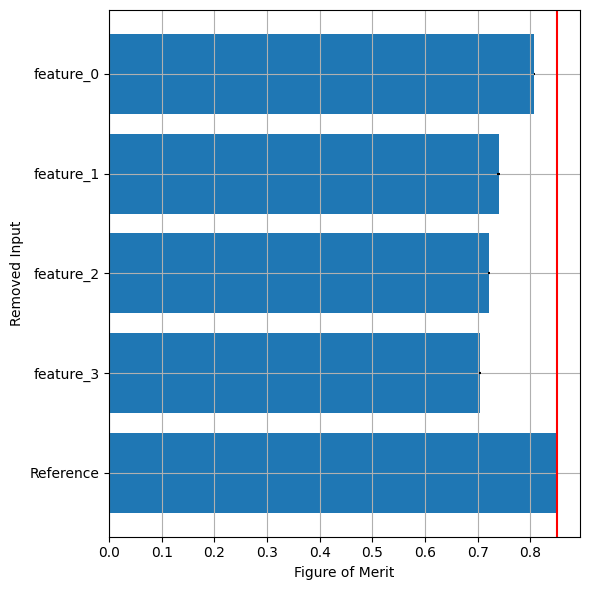

In [12]:
fig, ax = plt.subplots(figsize=(6, 6)) 
    
data = df_data.copy()

df_relevance = pd.read_csv(os.path.join(model_path,'%s_%s_relevance.csv'%(df_config['hash_id'][train_id], model_type)),index_col=0)

y = np.arange(df_relevance.shape[0])
x = df_relevance.mean(axis=1).values
x_err = df_relevance.std(axis=1).values

ax.barh(y, x, xerr=x_err, align='center')

ax.set_yticks(y, labels=df_relevance.index.values)
ax.invert_yaxis()  # labels read top-to-bottom

ax.set_xlabel('Figure of Merit')
ax.set_ylabel('Removed Input')
plt.axvline(x=np.mean(df_relevance.loc['Reference']), color='r', linestyle='-')
plt.tight_layout()

plt.grid()
plt.show()